# Lesson6 ニューラルネットに画像を生成させよう

## 目次

- Section5 参考
  - 5.1 VAE

In [ ]:
!pip uninstall -y tensorflow

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1


In [ ]:
!pip install tensorflow-gpu==1.13.1 tensorflow-tensorboard==0.4.0rc3 Keras==2.1.2

     |████████████████████████████████| 345.0MB 47kB/s 
     |████████████████████████████████| 1.7MB 51.9MB/s 
     |████████████████████████████████| 307kB 45.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 368kB 34.1MB/s 
     |████████████████████████████████| 3.2MB 55.0MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp37-none-any.whl size=107222 sha256=96d547b821df71e6fdb2afbe79b3ac08ef09d3973a902c9cba3cf24af83bc25f
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensor

In [ ]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

2.1.2
1.13.1


In [ ]:
# MNISTのロードと表示のための関数です。後で使うので読み込んでおいて下さい。
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    if data == 'mnist':
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    if dim == 3:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
        x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
        
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]
    
    return  x_train, x_test, y_train, y_test

### 5.1 VAE

今回は深層生成モデルのGANの実装をメインに扱いましたが、深層生成モデルはGANだけではありません。

興味のある方は、その例として Variational Auto Encoder (VAE)というモデルを使ってニューラルネットに画像生成に取り組んでみましょう。

### 5.1.1 VAEの概要

VAEではデータの潜在的な意味を表す潜在変数(z)からデータを生成する確率分布( $p_θ(x|z)$ ) を求めます。

潜在的な意味とは、例えばMNISTの手書き文字であれば、文字であることや筆跡などがあたります。
以下ではMNISTを例に話を進めていきます。


下の図のようにMNISTのデータセットの入力の「1」という手書き文字の画像を潜在変数 **z**に変換し、確率分布　$p_θ(x|z)$　によって入力画像を再現するネットワークを考えます。

このとき、入力を潜在変数に変換するネットワークのことを **Encoder**、潜在変数から出力として入力画像を再現するネットワークのことを **Decoder**　といいます。

確率分布　$p_θ(x|z)$　を求めることによって任意の潜在変数から手書き文字画像と似た画像を出力出来るようになります。

<img src='figures/vae1_var2.png' alt='vae_1'>

Encoderでは入力の画像から潜在変数zをサンプルする必要があり、VAEでは潜在変数のガウス分布性を仮定します。

そのため、以下のように入力からサンプルするためのパラメータとしてガウス分布の平均と分散を出力することを行います。

<img src='figures/vae2_var2.png' alt='vae_2'>

以上をふまえて、作成するモデルは以下のようなモデルを構築することになります。

<img src='figures/vae_3.png' alt='vae_3'>

### 5.1.2 Encoder

今回の実装ではEncoderにあたる層は1層のみです。

In [ ]:
batch_size = 100
original_dim = 784 # 28x28 MNIST| digits
latent_dim = 2
intermediate_dim = 256

In [ ]:
from tensorflow.keras.layers import Input, Dense

x = Input(batch_shape=(batch_size, original_dim)) # 入力
h = Dense(intermediate_dim, activation='relu')(x) # Encoderの層
z_mean = Dense(latent_dim)(h) # 潜在変数の平均 μ
z_log_var = Dense(latent_dim)(h) #潜在変数の分散 σのlog

Instructions for updating:
Colocations handled automatically by placer.


### 補足

今回はEncoderの出力として分散のlogとして出力を行っていますが、これは分散の値域を正にするためです。分散は $\log(z\_log\_var)$とすることで得られます。
また、関数の出力が正となるsoftplus関数を使用して分散も表現することも可能です。
softplus関数については[こちら](http://tecmemo.wpblog.jp/2017/01/08/dl_activation-function/)をご参照下さい。

### 5.1.3 潜在変数

Encoderで出力した平均μと分散σから潜在変数zをサンプリングします。

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

# 潜在変数のサンプリング
# 平均と分散を受けて、潜在変数をサンプリングします。
# z = μ + εΣ
# εは標準正規分布
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=1.0)
    return z_mean + K.exp(z_log_var) * epsilon

In [ ]:
# Lambdaを使って式をwrap
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### 5.1.4 Decoder

潜在変数zから画像を生成するDecoderを定義します。

In [ ]:
from tensorflow.keras.layers import Dense

decoder_h = Dense(intermediate_dim, activation='relu') # Decoderの中間層
decoder_x = Dense(original_dim, activation='sigmoid') # 出力を行うDecoderの層
h_decoded = decoder_h(z)
x_decoded = decoder_x(h_decoded)

### 5.1.5 Loss

周辺尤度の変分下界の最大化によって最適化を行います。

Lossとしては以下に示す復元誤差と正則化項の和になります。
(なお、デコーダにベルヌーイ分布を仮定するため復元誤差は負の交差エントロピー誤差となります。）

#### 復元誤差

$ \sum_{k=1}^{n} ( x_k \log(y_k) + (1-x_k) \log(1-y_k) ) $

#### 正則化項

$-\frac{1}{2}\sum_{k=1}^{n} ( 1 + \log(\sigma_i^2) - \mu_i^2 - \sigma_i^2 )$

ここでLossを定義するために自作のLayerを用意します。

KerasのLayer classを継承したクラスでcallメソッドの中で `add_loss`というメソッドを用いてlossを定義することが出来ます。

### 補足: 正則化項の意味

#### 1. VAEと多様体学習

VAEは多様体学習を行うことを目的としています。例えば、以下のように2次元の空間上にデータを表現出来るようにすることが目的となります。正則化項の制限によってこの多様体の学習がうまく出来るようになります。

<img src='figures/vae_suppliment.png' alt='vae_suppliment'>

( 引用: [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) )


#### 2. 正則化項の役割

ただし、正則化項が強く作用すると画像の特徴の情報が小さくなるのも確かで、正則化項を段々と強くかける（正則化項に係数をかけて、その係数を学習が進むにつれて0から増やしていく）といった学習方法もあります。
また、その係数を1よりもあえて大きく取ることで、disentangleな情報を表現出来ることも知られています(β-VAE)。disentangleな情報が出来るとは例えば以下のように「方向」、「幅」、「脚のスタイル」を多様体学習した潜在変数の軸ごとに獲得出来るということです。

<img src='figures/vae_suppliment2.png' alt='vae_suppliment2'>

( 引用: [β-VAE: LEARNING BASIC VISUAL CONCEPTS WITH A CONSTRAINED VARIATIONAL FRAMEWORK](https://openreview.net/pdf?id=Sy2fzU9gl))

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import metrics

class CustomVariationalLayer(Layer): # Layer classの継承
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded) # 復元誤差: Reconstruction Error
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # 正則化項: KL Divergence
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs) # Layer class のadd_lossを利用
        return x # 実質的には出力は利用しない

In [ ]:
from tensorflow.keras.models import Model

y = CustomVariationalLayer()([x, x_decoded])
vae = Model(x, y) # xをinputにyを出力, 出力は実質関係ない
vae.compile(optimizer='rmsprop', loss=None) # CustomVariationalLayerで追加したLossを利用するのでここでのlossはNoneとする

### 5.1.6 MNISTによる学習

MNISTのデータセットによって学習を行います。

In [ ]:
x_train, x_test, _, _ = load_mnist(dim=1) # 1次元のmnist dataを読み込む (batch size) x 784

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
vae.fit(x_train, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None), verbose=2)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 4s - loss: 187.3949 - val_loss: 170.1358
Epoch 2/10
 - 2s - loss: 167.8331 - val_loss: 165.9259
Epoch 3/10
 - 2s - loss: 164.0410 - val_loss: 163.0229
Epoch 4/10
 - 2s - loss: 161.6048 - val_loss: 160.8714
Epoch 5/10
 - 2s - loss: 159.6798 - val_loss: 159.1489
Epoch 6/10
 - 2s - loss: 158.0142 - val_loss: 157.5119
Epoch 7/10
 - 2s - loss: 156.6525 - val_loss: 156.3667
Epoch 8/10
 - 2s - loss: 155.6283 - val_loss: 155.8056
Epoch 9/10
 - 2s - loss: 154.8141 - val_loss: 154.9962
Epoch 10/10
 - 2s - loss: 154.1101 - val_loss: 154.1783


### 5.1.7 手書き文字の生成

任意の潜在変数によって手書き文字が出力出来ることを実際に画像を生成して確認してみましょう。

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# 入力として潜在変数を入れられるようにする
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded = decoder_x(_h_decoded)
generator = Model(decoder_input, _x_decoded)

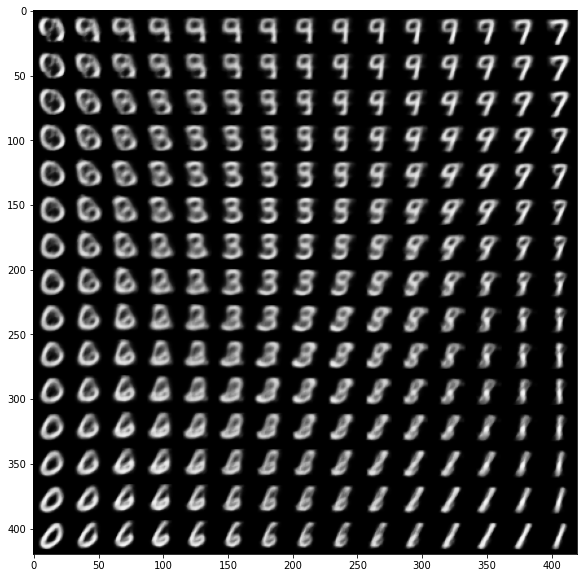

In [ ]:
from scipy.stats import norm

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# ppf: パーセント点関数

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample) # generatorに指定した潜在変数を入れて出力をみる（この出力が新たに生成された文字にあたる）
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()